![MuJoCo Banner](https://mujoco.readthedocs.io/en/3.0.0/_static/banner.svg)

In [1]:
# @title MuJoCo Installation
!pip install -q mujoco

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.3/5.3 MB 23.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 208.2/208.2 kB 26.2 MB/s eta 0:00:00


In [2]:
# @title Check if installation was successful

from google.colab import files

import distutils.util
import os
import subprocess
if subprocess.run('nvidia-smi').returncode:
  raise RuntimeError(
      'Cannot communicate with GPU. '
      'Make sure you are using a GPU Colab runtime. '
      'Go to the Runtime menu and select Choose runtime type.')

# Add an ICD config so that glvnd can pick up the Nvidia EGL driver.
# This is usually installed as part of an Nvidia driver package, but the Colab
# kernel doesn't install its driver via APT, and as a result the ICD is missing.
# (https://github.com/NVIDIA/libglvnd/blob/master/src/EGL/icd_enumeration.md)
NVIDIA_ICD_CONFIG_PATH = '/usr/share/glvnd/egl_vendor.d/10_nvidia.json'
if not os.path.exists(NVIDIA_ICD_CONFIG_PATH):
  with open(NVIDIA_ICD_CONFIG_PATH, 'w') as f:
    f.write("""{
    "file_format_version" : "1.0.0",
    "ICD" : {
        "library_path" : "libEGL_nvidia.so.0"
    }
}
""")

# Configure MuJoCo to use the EGL rendering backend (requires GPU)
print('Setting environment variable to use GPU rendering:')
%env MUJOCO_GL=egl

try:
  print('Checking that the installation succeeded:')
  import mujoco
  mujoco.MjModel.from_xml_string('<mujoco/>')
except Exception as e:
  raise e from RuntimeError(
      'Something went wrong during installation. Check the shell output above '
      'for more information.\n'
      'If using a hosted Colab runtime, make sure you enable GPU acceleration '
      'by going to the Runtime menu and selecting "Choose runtime type".')

print('Installation successful.')

Setting environment variable to use GPU rendering:
env: MUJOCO_GL=egl
Checking that the installation succeeded:
Installation successful.


In [3]:
# @title Import packages for plotting and creating graphics
import time
import itertools
import numpy as np
from typing import Callable, NamedTuple, Optional, Union, List

# Graphics and plotting.
print('Installing mediapy:')
!command -v ffmpeg >/dev/null || (apt update && apt install -y ffmpeg)
!pip install -q mediapy
import mediapy as media
import matplotlib.pyplot as plt

# More legible printing from numpy.
np.set_printoptions(precision=3, suppress=True, linewidth=100)

Installing mediapy:
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 23.9 MB/s eta 0:00:00


In [4]:
# @title XML Model
xml = """
<mujoco>
    <option	timestep="0.01" gravity="0 0 -9.81" density="1" viscosity="18e-3" integrator="RK4"/>

    <asset>
        <texture builtin="gradient" type="skybox" height="100" width="100" rgb1="1 1 1" rgb2="0 0 0"/>
        <texture name="texgeom" builtin="flat" height="1278" mark="cross" markrgb="1 1 1" random="0.01" rgb1="0.8 0.6 0.4" rgb2="0.8 0.6 0.4" type="cube" width="127"/>
        <texture name="texplane" builtin="checker" height="100" width="100" rgb1="0 0 0" rgb2="0.8 0.8 0.8" type="2d"/>
        <material name="MatPlane" reflectance="0.5" shininess="1" specular="1" texrepeat="60 60" texture="texplane"/>
        <material name="geom" texture="texgeom" texuniform="true"/>
    </asset>

    <worldbody>
        <light cutoff="100" diffuse="1 1 1" dir="-0 0 -1.3" directional="true" exponent="1" pos="0 0 1.3" specular=".1 .1 .1"/>
        <geom conaffinity="1" condim="3" material="MatPlane" name="floor" pos="0 0 0" rgba="0.4 0.3 0.3 1" size="5 5 0.2" type="plane"/>
        <camera name="fixed" pos="-0.3 -1 1.5" euler="0 0 0"/>
        <camera name="fixed1" pos="-0.3 -0.7 .7" xyaxes="1 0 0 0 1 2" mode="track" />


        <body name="core" pos="-.3 -.1 0.3" euler="0 0 45">

            <camera name="my_cam" pos="0 0 0" euler="0 0 0"/>
            <site name="center_body" type="sphere" pos="0 0 0" size=".01" quat="1 0 0 0" rgba=".3 .8 .3 1"/>


            <geom name="core_geom" type="box" pos="0 0 0" euler="0 0 45" size=".04 .04 .02" rgba=".8 .2 0 1" mass=".1"/>

            <joint name="root" type="free" damping="0" armature="0" pos="0 0 0" limited="false"/>

            <geom name="arm_front0" type="box" pos=".08 0 0" size=".04 .005 .005" quat="1 0 0 0" rgba=".8 .8 .8 1" mass=".02"/>
            <geom name="arm_back0" type="box" pos="-.08 0 0" size=".04 .005 .005" quat="0 0 0 1" rgba=".8 .8 .8 1" mass=".02"/>
            <geom name="arm_left0" type="box" pos="0 .08 0" size=".04 .005 .005" quat=".707 0 0 .707" rgba=".8 .8 .8 1" mass=".02"/>
            <geom name="arm_right0" type="box" pos="0 -.08 0" size=".04 .005 .005" quat=".707 0 0 -.707" rgba=".8 .8 .8 1" mass=".02"/>

            <body name="arm_front1" pos=".12 0 0">
                <geom type="box" pos=".01 0 .005" size=".01 .005 .01" quat="1 0 0 0" rgba="1 .1 0 1" mass=".02"/>
                <body name="thruster0" pos="0.01 0 0.015">
                    <geom type="cylinder" pos="0 0 .0025" size=".05 .0025" quat="1 0 0 0" rgba=".3 1 .3 0.5" mass=".005"/>
                    <site name="motor0" type="cylinder" pos="0 0 .0025" size=".01 .0025" quat="1 0 0 0" rgba=".3 .8 .3 1"/>
                </body>
            </body>

            <body name="arm_back1" pos="-.12 0 0">
                <geom type="box" pos="-.01 0 .005" size=".01 .005 .01" quat="0 0 0 1" rgba="1 .1 0 1" mass=".02"/>
                <body name="thruster1" pos="-0.01 0 .015">
                    <geom type="cylinder" pos="0 0 .0025" size=".05 .0025" quat="1 0 0 0" rgba=".3 1 .3 0.5" mass=".005"/>
                    <site name="motor1" type="cylinder" pos="0 0 .0025" size=".01 .0025" quat="1 0 0 0" rgba=".3 .8 .3 1"/>

                </body>
            </body>

            <body name="arm_left1" pos="0 .12 0">
                <geom type="box" pos="0 .01 .005" size=".01 .005 .01" quat=".7071068 0 0 .7071068" rgba="1 .1 0 1" mass=".02"/>
                <body name="thruster2" pos="0 0.01 0.015">
                    <geom type="cylinder" pos="0 0 .0025" size=".05 .0025" quat="1 0 0 0" rgba=".3 1 .3 0.5" mass=".005"/>
                    <site name="motor2" type="cylinder" pos="0 0 .0025" size=".01 0.0025" quat="1 0 0 0" rgba=".3 .8 .3 1"/>

                </body>
            </body>

            <body name="arm_right1" pos="0 -.12 0">
                <geom type="box" pos="0 -.01 .005" size=".01 .005 .01" quat=".7071068 0 0 -.7071068" rgba="1 .1 0 1" mass=".02"/>
                <body name="thruster3" pos="0 -0.01 .015">
                    <geom type="cylinder" pos="0 0 .0025" size=".05 .0025" quat="1 0 0 0" rgba=".3 1 .3 0.5" mass=".005"/>
                    <site type="cylinder" pos="0 0 .0025" size=".01 .0025" quat="1 0 0 0" rgba=".3 .8 .3 1" name="motor3"/>

                </body>

            </body>

        </body>
    </worldbody>

    <actuator>
        <motor ctrllimited="true" ctrlrange="0 100" gear="0  0. 1. 0. 0.  0.1" site="motor0"/>
        <motor ctrllimited="true" ctrlrange="0 100" gear="0  0. 1. 0. 0.  0.1" site="motor1"/>
        <motor ctrllimited="true" ctrlrange="0 100" gear="0  0. 1. 0. 0. -0.1" site="motor2"/>
        <motor ctrllimited="true" ctrlrange="0 100" gear="0  0. 1. 0. 0. -0.1" site="motor3"/>
    </actuator>

    <sensor>
      <gyro site="center_body" />
      <accelerometer site="center_body" />
    </sensor>


</mujoco>
"""

[ 0.  0.  0. -0. -0.  0.]


""

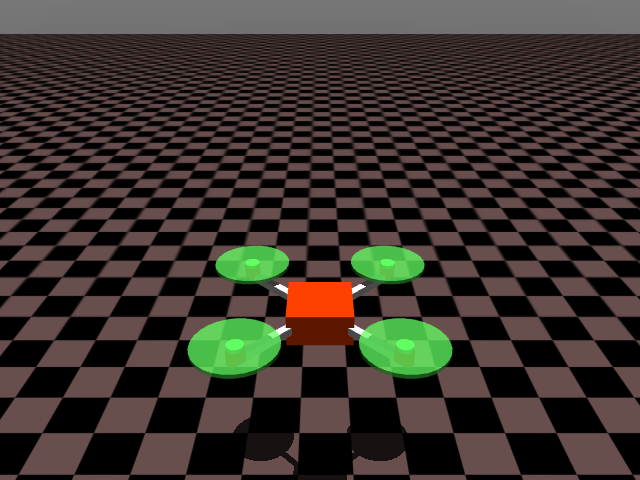

In [5]:
# @title Visualiza Model
model = mujoco.MjModel.from_xml_string(xml)
data = mujoco.MjData(model)
renderer = mujoco.Renderer(model)

mujoco.mj_forward(model, data)
# renderer.update_scene(data)
renderer = mujoco.Renderer(model, 480, 640)
# media.show_image(renderer.render())

# enable joint visualization option:
scene_option = mujoco.MjvOption()
scene_option.flags[mujoco.mjtVisFlag.mjVIS_JOINT] = False

# show axis & make transparent
# scene_option.frame = mujoco.mjtFrame.mjFRAME_GEOM
# scene_option.flags[mujoco.mjtVisFlag.mjVIS_TRANSPARENT] = True
# 2 0
# 1 3

print(data.sensordata)
renderer.update_scene(data, scene_option=scene_option, camera="fixed1")
frame = renderer.render()
media.show_image(frame)

In [8]:
# @title Check PID

import math

# ==============================================
# ================ MODEL PARAMS ================
# ==============================================
# Make model and data
model = mujoco.MjModel.from_xml_string(xml)
data = mujoco.MjData(model)
# # Make renderer, render and show the pixels
renderer = mujoco.Renderer(model, 480, 640)
# show axis & make transparent
scene_option.frame = mujoco.mjtFrame.mjFRAME_GEOM
scene_option.flags[mujoco.mjtVisFlag.mjVIS_TRANSPARENT] = True
dt = model.opt.timestep
# 2 0
# 1 3

# ==============================================
# ============= SIMULATION PARAMS ==============
# ==============================================
duration = 12  # (seconds)
framerate = 30  # (Hz)
# Simulate and display video.
frames = []
mujoco.mj_resetData(model, data)  # Reset state and time.

# ==============================================
# ================= VARIABLES ==================
# ==============================================
# PID parameters
kp = 15.0
ki = 0.005
kd = 50.0

cumul = 0
cumul_y = 0

lastE = 0
lastE_y = 0


# prev values
prev_yaw_err = 0
prev_yaw_sp = 0
prev_roll_err = 0
prev_roll_sp = 0
prev_pitch_err = 0
prev_pitch_sp = 0

pBetaE = 0
psp2 = 0
psp1 = 0
prevEuler = 0

# setpoints
t_sp = 0.4
r_sp = 0.0
p_sp = 0.0
y_sp = 0.6

y_pos = 0

value_pos = []
value_sp = []

xacc_vals = []
yacc_vals = []
zacc_vals = []
xgyro_vals = []
ygyro_vals = []
zgyro_vals = []
# 2 0
# 1 3
while data.time < duration:
    mujoco.mj_step(model, data)

    if(data.time > 0.5*duration):
      t_sp = 0.2
      y_sp = 0.0

    # altitude
    t_pos = data.qpos[2]
    # acceleration
    xacc = data.sensordata[3]
    yacc = data.sensordata[4]
    zacc = data.sensordata[5]
    # gyroscope
    xgyro = data.sensordata[0]
    ygyro = data.sensordata[1]
    zgyro = data.sensordata[2]

    xacc_vals.append(xacc)
    yacc_vals.append(yacc)
    zacc_vals.append(zacc)

    xgyro_vals.append(xgyro)
    ygyro_vals.append(ygyro)
    zgyro_vals.append(zgyro)

    # vertical control
    e = t_sp - t_pos
    pv = kp * e
    cumul = cumul + e
    thrust = pv + ki * cumul + kd * (e - lastE)
    lastE = e

    # horizontal control
    r_pos = math.atan2(yacc, math.sqrt(xacc**2 + zacc**2))*180/math.pi
    p_pos = math.atan2(-1 * yacc , math.sqrt(xacc**2 + zacc**2))*180/math.pi
    y_pos += zgyro*dt
    # yaw
    yaw_err = y_pos - y_sp
    yaw = 0.25*yaw_err+2.1*(yaw_err-prev_yaw_err)
    prev_yaw_err=yaw_err
    # yaw += 1*(y_sp-prev_yaw_sp)
    # prev_yaw_sp = y_sp

    # roll
    roll_err = data.qpos[4] - r_sp
    # roll_err = r_pos - r_sp
    roll = -0.25*roll_err-2.1*(roll_err-prev_roll_err)
    prev_roll_err=roll_err
    # roll -= 1*(y_sp-prev_roll_sp)
    # prev_roll_sp = y_sp

    # pitch
    # pitch_err = data.qpos[3] - p_sp
    # pitch = 0.25*roll_err-2.1*(pitch_err-prev_pitch_err)
    # prev_pitch_err=roll_err

    # correlations
    pitch = 0.0
    roll = 0.0
    # yaw = 0

    # real
    data.ctrl[0] = thrust * (1 - yaw + roll + pitch)
    data.ctrl[1] = thrust * (1 - yaw - roll - pitch)
    data.ctrl[2] = thrust * (1 + yaw - roll + pitch)
    data.ctrl[3] = thrust * (1 + yaw + roll - pitch)

    # to plot it
    value_pos.append(y_pos)
    value_sp.append(y_sp)

    if len(frames) < data.time * framerate:
        renderer.update_scene(data, scene_option=scene_option, camera="fixed1")
        # renderer.update_scene(data, camera="fixed1")
        pixels = renderer.render()
        frames.append(pixels)

media.show_video(frames, fps=framerate)

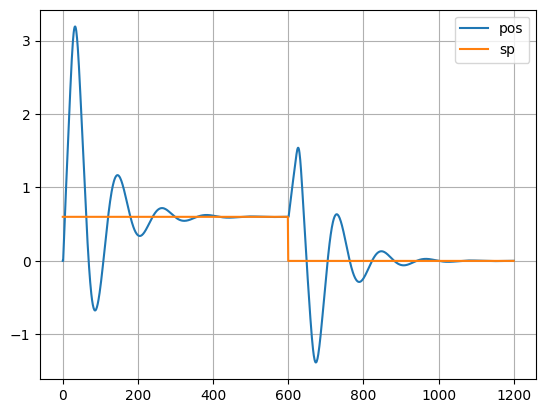

In [7]:
plt.plot(value_pos, label="pos")
plt.plot(value_sp, label="sp")
plt.legend()
plt.grid()
plt.show()